In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os

# Add the PowerFactory Python API to the path
sys.path.append("C:/Program Files/DIgSILENT/PowerFactory 2024 SP4A/Python/3.12")

# Add the src directory to Python path for development
sys.path.append(os.path.join(os.getcwd(), "..")) 

import powerfactory as pf
from src.pfapi.core.Network import Network
from src.pfapi.utils.PFHelpers import init_project
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Initialize PowerFactory application and import 39-bus system model for this example
print("Initializing PowerFactory application...")
app: pf.Application = pf.GetApplicationExt()
app.Show()
init_project(app, "MAGISTRSKA\\39 Bus New England OG")

Initializing PowerFactory application...
Successfully activated project: 39 Bus New England OG


In [2]:
allSG = app.GetCalcRelevantObjects("*.ElmSym", 1, 1, 1)
for sg in allSG:
    sg_type = sg.GetAttribute("typ_id")
    sg_type.SetAttribute("model_inp", "det") # Before "det" as Standard or "cls" as classical

In [114]:
app.Show()

In [137]:
'''Run script for obtaining rms results'''
from obtain_rms_results import obtain_rms_results
app.Hide()
obtain_rms_results(app, "rms_sim_results_OG")
app.Show()

Ime Rezultatov:  All calculations
All generators:  10
Generators:  10
Generators:  ['G 01', 'G 02', 'G 03', 'G 04', 'G 05', 'G 06', 'G 07', 'G 08', 'G 09', 'G 10']
Processing generator outage for generator nr. 1: G 01
Processing generator outage for generator nr. 2: G 02
Processing generator outage for generator nr. 3: G 03
Processing generator outage for generator nr. 4: G 04
Processing generator outage for generator nr. 5: G 05
Processing generator outage for generator nr. 6: G 06
Processing generator outage for generator nr. 7: G 07
Processing generator outage for generator nr. 8: G 08
Processing generator outage for generator nr. 9: G 09
Processing generator outage for generator nr. 10: G 10


In [158]:
# Initialize the Network object (reads topology and connected components)
try:
    app.Hide()  # Hide the PowerFactory GUI for cleaner output
    network = Network(app, base_mva=100.0)
except Exception as e:
    print("Failed to initialize the network. Ensure that the PowerFactory model is loaded correctly.")
    print(e)
    app.Show()  # Show the GUI again if initialization fails
app.Show()

# Obtain network admittance matrix
from src.pfapi.utils.AdmittanceMatrix import build_admittance_matrix
import pandas as pd
Y_bus = build_admittance_matrix(network, as_dataframe=True)
# Y_bus.head() # type: ignore

INFO: Processed 39 valid busbars
INFO: Running load flow analysis to obtain busbar results...
INFO: Reading network elements from PowerFactory...
INFO: Successfully read 75 classified elements from PF
INFO: Classified element counts:
INFO:   ElmLne: 34
INFO:   ElmTr2: 12
INFO:   ElmLod: 19
INFO:   ElmSym: 10


In [159]:
from src.pfapi.utils.AdmittanceMatrix import reduce_matrix
import numpy as np
import pandas as pd

# Reduce the admittance matrix to only generator buses
Y_bus = build_admittance_matrix(network, as_dataframe=False)
if not isinstance(Y_bus, np.ndarray):
    raise TypeError("Y_bus must be a numpy ndarray, but got type {}".format(type(Y_bus)))
reduced_Y_bus, generator_bus_names_order = reduce_matrix(Y_bus, network)

# Convert generator_bus_names to generator_names order
generator_names_order = [network.get_generator_name_from_busbar(bus) for bus in generator_bus_names_order]

# Display the reduced admittance matrix as a DataFrame for better readability
reduced_Y_bus_df = pd.DataFrame(reduced_Y_bus, index=generator_bus_names_order, columns=generator_bus_names_order)
reduced_Y_bus_df.head()

,Bus 30,Bus 31,Bus 32,Bus 33,Bus 34,Bus 35,Bus 36,Bus 37,Bus 38,Bus 39
Bus 30,0.859850-12.410380j,0.306448+0.558391j,0.374072+0.707095j,0.424743+0.686408j,0.188347+0.255544j,0.424720+0.706965j,0.346726+0.572530j,0.296561+1.835529j,0.431834+0.998288j,1.260205+3.738456j
Bus 31,0.306448+ 0.558391j,0.263320-6.810517j,0.286075+0.908012j,0.226333+0.325294j,0.099076+0.120307j,0.226865+0.335372j,0.185082+0.271525j,0.156533+0.290609j,0.180415+0.221756j,0.746867+1.777750j
Bus 32,0.374072+ 0.707095j,0.286075+0.908012j,0.375311-8.073677j,0.289701+0.458566j,0.128158+0.170531j,0.289815+0.472379j,0.236565+0.382535j,0.193880+0.370841j,0.228275+0.294335j,0.846432+1.914648j
Bus 33,0.424743+ 0.686408j,0.226333+0.325294j,0.289701+0.458566j,0.763721-8.823885j,0.347100+1.009600j,0.461655+0.948199j,0.377396+0.768202j,0.251206+0.388678j,0.315561+0.405142j,0.730389+1.008973j
Bus 34,0.188347+ 0.255544j,0.099076+0.120307j,0.128158+0.170531j,0.347100+1.009600j,0.225477-4.219712j,0.211150+0.356989j,0.172391+0.289114j,0.110844+0.144361j,0.136595+0.148766j,0.318427+0.372257j


In [160]:
from src.pfapi.core.synchro_power_coefficients import calculate_power_distribution_ratios

# Calculate synchronizing power coefficients
GEN_OUT = "G 07" # Define the generator name where outage occurs
ratios = calculate_power_distribution_ratios(reduced_Y_bus, generator_bus_names_order, network, GEN_OUT)
    
# Display the synchronizing power coefficients
print(f"Synchronizing power coefficients for outage of generator {GEN_OUT}:")
print(ratios)

INFO: Calculating synchronizing power coefficients for disturbance bus: Bus 36 at index 6


Synchronizing power coefficients for outage of generator G 07:
[0.10143492 0.04810607 0.06777357 0.13610211 0.05122227 0.32869485
 0.         0.0574525  0.05996179 0.14925193]


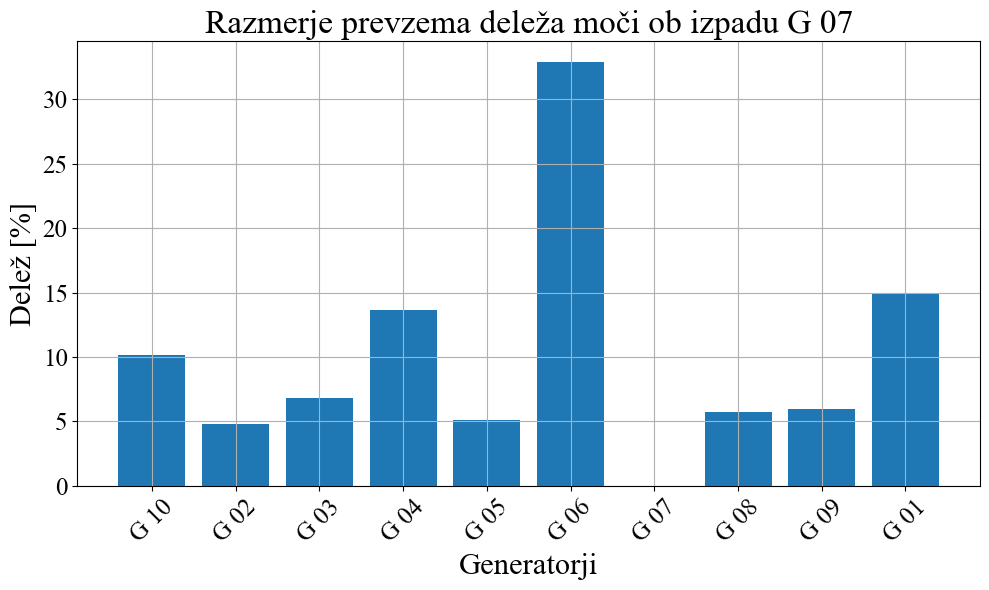

In [161]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['svg.fonttype'] = 'none'  # Embed fonts as text, not paths

plt.figure(figsize=(10, 6))
plt.bar(generator_names_order, ratios * 100)
plt.xlabel('Generatorji', fontsize=22, fontname='Times New Roman')
plt.ylabel('Delež [%]', fontsize=22, fontname='Times New Roman')
plt.title('Razmerje prevzema deleža moči ob izpadu {}'.format(GEN_OUT), fontsize=24, fontname='Times New Roman')
plt.xticks(rotation=45, fontsize=18, fontname='Times New Roman')
plt.yticks(fontsize=18, fontname='Times New Roman')
plt.grid(True)
plt.tight_layout()
plt.show()

567.0723462000001


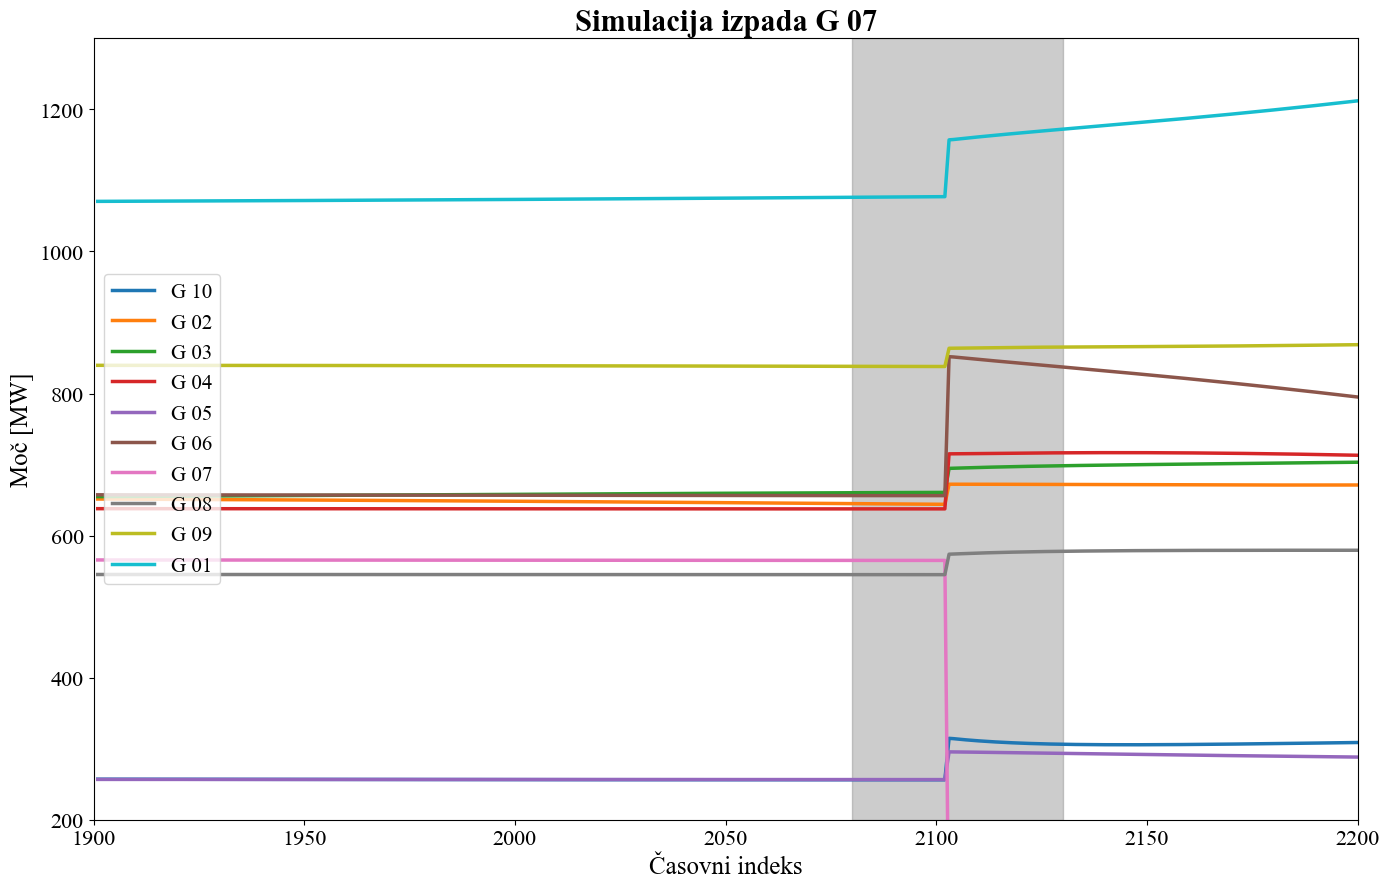

In [162]:
import matplotlib.pyplot as plt
from get_simulation_data import get_simulation_data

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Get the simulation data
rdP, simulation_gen_order, data = get_simulation_data(GEN_OUT, f"./rms_sim_results_OG")

plt.figure(figsize=(14, 9))
for i, gen in enumerate(generator_names_order):
    plt.plot(data[gen][1900:2200], label=gen, linewidth=2.5)
plt.xlabel('Časovni indeks', fontsize=18, fontname='Times New Roman')
plt.ylabel('Moč [MW]', fontsize=18, fontname='Times New Roman')
plt.title(f'Simulacija izpada {GEN_OUT}', fontsize=22, fontname='Times New Roman', fontweight='bold')
plt.ylim(200, 1300)
plt.xlim(1900, 2200)

plt.legend(fontsize=15, loc='center left')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(False)
plt.tight_layout()

# Mark area from 1990 to 2020 in gray
plt.axvspan(2080, 2130, color='gray', alpha=0.4)

# Save as SVG with high quality settings
plt.savefig('slike_std/simulation_plot.svg', format='svg', bbox_inches='tight', 
           facecolor='white', edgecolor='none', transparent=False)
plt.show()

[14.10476652  4.98729838  5.96946301 13.66059739  6.88143921 34.495424
  0.          5.07989609  4.52998286 10.29113253]


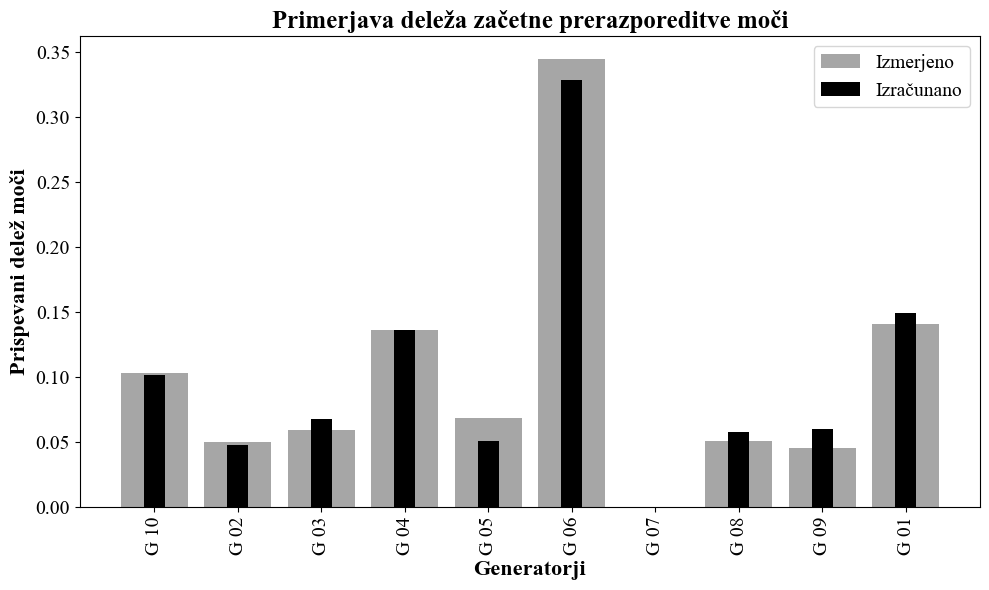

In [163]:
# Plot the synched_simulation_data values
import matplotlib.pyplot as plt

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['svg.fonttype'] = 'none'  # Embed fonts as text, not paths
print(rdP)

# Reorder rdP to match gen_order
rdP_reordered = []
for gen in generator_names_order:
    # Find the index of this generator in simulation_gen_order
    sim_index = simulation_gen_order.index(gen)
    # Add the corresponding rdP value
    rdP_reordered.append(rdP[sim_index])

# Convert back to numpy array if needed
rdP_reordered = np.array(rdP_reordered)

plt.figure(figsize=(10, 6))
# gen_names = ["G1", "G3", "G4", "G0", "G2"]
bar2 = plt.bar(generator_names_order, rdP_reordered/100, 0.8, color='gray', label='Izmerjeno', alpha=0.7)
bar1 = plt.bar(generator_names_order, ratios, 0.25, color='black', label='Izračunano', alpha=1)
plt.xlabel('Generatorji', fontsize=16, fontweight='bold')
plt.ylabel('Prispevani delež moči', fontsize=16, fontweight='bold')
plt.title('Primerjava deleža začetne prerazporeditve moči', fontsize=18, fontweight='bold')
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.legend(fontsize=14)
plt.tight_layout()

# Save as SVG with high quality settings
plt.savefig('slike_std/power_contribution_comparison.svg', format='svg', bbox_inches='tight', 
           facecolor='white', edgecolor='none', transparent=False)

plt.show()

In [164]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from src.pfapi.core.synchro_power_coefficients import calculate_for_multiple_outages

# Create the power distribution matrix using all generator outages
coefficients, gen_order = calculate_for_multiple_outages(reduced_Y_bus, generator_bus_names_order, network, generator_names_order)

# Apply PCA to reduce to n components
pca = PCA(n_components=2)
coefficients_np = np.array(coefficients)
power_distribution_matrix_transformed = pca.fit_transform(coefficients_np)

# Print PCA explained variance ratio
print(f"PCA komponenta 1 razloži {pca.explained_variance_ratio_[0]:.2%} variance")
print(f"PCA komponenta 2 razloži {pca.explained_variance_ratio_[1]:.2%} variance")
print(f"Skupaj razloženo: {sum(pca.explained_variance_ratio_):.2%}")

PCA komponenta 1 razloži 31.88% variance
PCA komponenta 2 razloži 20.60% variance
Skupaj razloženo: 52.48%


[0.10291133 0.04987298 0.05969463 0.13660597 0.06881439 0.34495424
 0.         0.05079896 0.04529983 0.14104767]
[0.10143492 0.04810607 0.06777357 0.13610211 0.05122227 0.32869485
 0.         0.0574525  0.05996179 0.14925193]
The new disturbance fits the most with generator index 6
G 07


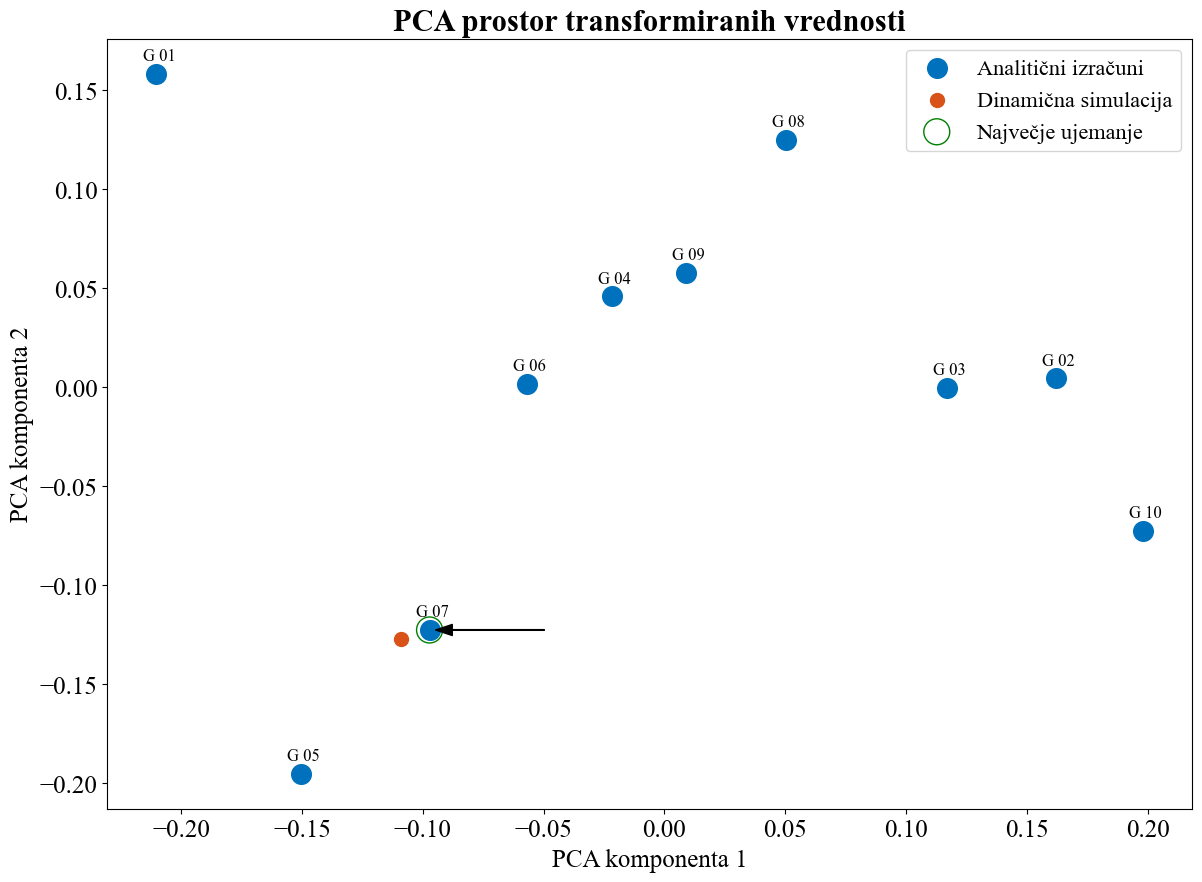

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from get_simulation_data import get_simulation_data

# Reorder rdP to match gen_order
rdP_reordered = []
for gen in generator_names_order:
    # Find the index of this generator in simulation_gen_order
    sim_index = simulation_gen_order.index(gen)
    # Add the corresponding rdP value
    rdP_reordered.append(rdP[sim_index])

# Convert back to numpy array if needed
rdP_reordered = np.array(rdP_reordered)

print(rdP_reordered/ 100)
print(ratios)

# Prepare data for PCA
sim_disturbance = np.array(np.array(rdP_reordered) / 100)
new_disturbance_transformed = pca.transform(sim_disturbance.reshape(1, -1))  # Transform the new disturbance

# Calculate Euclidean distances
distances = euclidean_distances(new_disturbance_transformed, power_distribution_matrix_transformed).flatten()

# Find the index of the minimum distance
best_fit_index = np.argmin(distances)

print(f"The new disturbance fits the most with generator index {best_fit_index}")
print(gen_order[best_fit_index])

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Plot PCA Scatter
plt.figure(figsize=(14, 10))
plt.scatter(power_distribution_matrix_transformed[:, 0], power_distribution_matrix_transformed[:, 1], color='#0072BD', label='Analitični izračuni', s=200)
plt.scatter(new_disturbance_transformed[:, 0], new_disturbance_transformed[:, 1], color='#D95319', label='Dinamična simulacija', s=100)
# Draw a green circle around the best match
plt.scatter(power_distribution_matrix_transformed[best_fit_index, 0], power_distribution_matrix_transformed[best_fit_index, 1], 
            color='green', label='Največje ujemanje', marker='o', s=350, facecolors='none')

# Add an arrow annotation pointing to the best match point
plt.annotate('', 
            xy=(power_distribution_matrix_transformed[best_fit_index, 0], power_distribution_matrix_transformed[best_fit_index, 1]),
            xytext=(power_distribution_matrix_transformed[best_fit_index, 0] + 0.05, power_distribution_matrix_transformed[best_fit_index, 1]),
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8),
            fontsize=10)

for i, txt in enumerate(gen_order):
    plt.annotate(txt, (power_distribution_matrix_transformed[i, 0], power_distribution_matrix_transformed[i, 1]), 
                xytext=(-10, 10), textcoords='offset points', fontsize=12)
    
plt.xlabel('PCA komponenta 1', fontsize=18)
plt.ylabel('PCA komponenta 2', fontsize=18)
plt.title('PCA prostor transformiranih vrednosti', fontsize=22, fontweight='bold')
plt.legend(loc='upper right', fontsize=16)
plt.grid(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.xlim(-0.4, 0.4)
# plt.ylim(-0.4, 0.4)
plt.savefig('slike_std/pca_disturbance_match_2D.svg', format='svg', bbox_inches='tight', 
           facecolor='white', edgecolor='none', transparent=False)
plt.show()


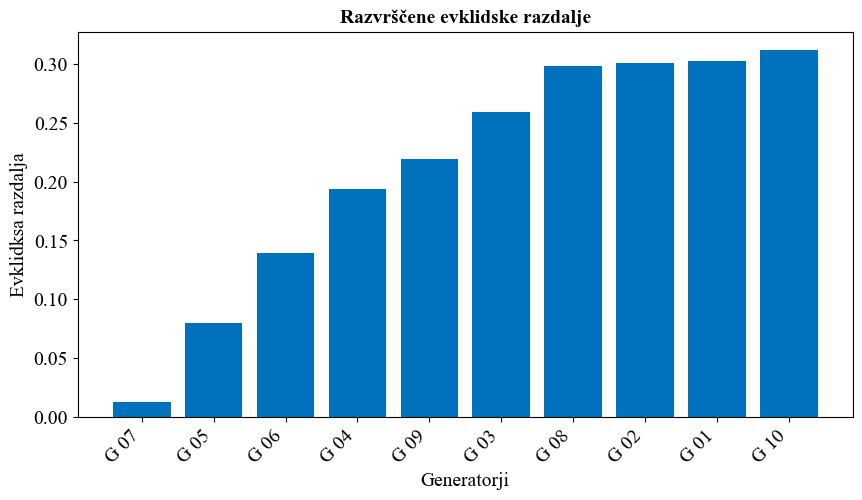

In [166]:
# BAR CHART: Sort distances from lowest to highest
sorted_indices = np.argsort(distances)
sorted_distances = distances[sorted_indices]
sorted_generators = [gen_order[i] for i in sorted_indices]  # Sort generator labels accordingly

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_distances)), sorted_distances, color='#0072BD')
plt.xticks(range(len(sorted_generators)), sorted_generators, rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Generatorji", fontsize=14)
plt.ylabel("Evklidksa razdalja", fontsize=14)
plt.title("Razvrščene evklidske razdalje", fontsize=14, fontweight='bold')
plt.savefig('slike_std/pca_disturbance_match.svg', format='svg', bbox_inches='tight', 
           facecolor='white', edgecolor='none', transparent=False)
plt.show()

In [167]:
match_count = 0
total_tests = len(generator_names_order)
mismatches = []

for test_gen in generator_names_order:
    print(f"\nTesting generator: {test_gen}")
    
    # Get the simulation data for this generator
    _rdP, _simulation_gen_order, _data = get_simulation_data(test_gen, f"./rms_sim_results_OG")

    # Reorder _rdP to match gen_order
    _rdP_reordered = []
    for gen in generator_names_order:
        sim_index = _simulation_gen_order.index(gen)
        _rdP_reordered.append(_rdP[sim_index])
    
    _rdP_reordered = np.array(_rdP_reordered)

    # Prepare data for PCA
    _sim_disturbance = np.array(np.array(_rdP_reordered) / 100)
    _new_disturbance_transformed = pca.transform(_sim_disturbance.reshape(1, -1))  # Transform the new disturbance

    # Calculate Euclidean distances to all generators in full PCA space
    distances = euclidean_distances(_new_disturbance_transformed, power_distribution_matrix_transformed).flatten()
    
    best_fit_index_global = np.argmin(distances)
    best_match_gen_global = gen_order[best_fit_index_global]

    print(f"Best match for {test_gen} is {best_match_gen_global} with distance {distances[best_fit_index_global]:.4f}")

    if test_gen == best_match_gen_global:
        match_count += 1
    else:
        mismatches.append((test_gen, best_match_gen_global))

success_rate = match_count / total_tests
print(f"\nSuccess rate: {success_rate:.2%} ({match_count}/{total_tests})")

if mismatches:
    print("\nMismatches:")
    for test_gen, matched_gen in mismatches:
        print(f"  {test_gen} -> {matched_gen}")



Testing generator: G 10
261.5107174799998
Best match for G 10 is G 10 with distance 0.0189

Testing generator: G 02
658.1389043999998
Best match for G 02 is G 02 with distance 0.0053

Testing generator: G 03
670.0442515499998
Best match for G 03 is G 03 with distance 0.0147

Testing generator: G 04
645.4074152500001
Best match for G 04 is G 04 with distance 0.0149

Testing generator: G 05
262.38676382999995
Best match for G 05 is G 07 with distance 0.0374

Testing generator: G 06
663.7419987499997
Best match for G 06 is G 06 with distance 0.0127

Testing generator: G 07
567.0723462000001
Best match for G 07 is G 07 with distance 0.0127

Testing generator: G 08
546.3075509699997
Best match for G 08 is G 08 with distance 0.0442

Testing generator: G 09
852.1373754099998
Best match for G 09 is G 09 with distance 0.0136

Testing generator: G 01
491.42533973
Best match for G 01 is G 01 with distance 0.0919

Success rate: 90.00% (9/10)

Mismatches:
  G 05 -> G 07
